In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.filters import sobel
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from skimage import data, color
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
from src.dataset_benchm import all_datasets

/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
trainloader, valloader, testloader = all_datasets(datasets='ovaskainen23', batch_size=100, in_channels= 4,
                                                  out_channels= 1, shape= 256, expand= True, dilate= True,
                                                  shuffle_train= True, do_transform= True)

# The ML model

In [9]:
# Define a learnable threshold model
class ThresholdModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.threshold = nn.Parameter(torch.tensor([0.5]))  # learnable scalar

    def forward(self, x):
        return torch.sigmoid(50 * (x - self.threshold))  # sigmoid for sharp binary-like output

In [10]:
# Initialize model, loss, and optimizer
model = ThresholdModel()
criterion = nn.BCELoss()  # since output is between 0 and 1
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(200):
    for x, y in loader:
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Threshold: {model.threshold.item():.4f}")

Epoch 0, Loss: 5.6141, Threshold: 0.4900
Epoch 20, Loss: 1.9444, Threshold: 0.2926
Epoch 40, Loss: 0.1531, Threshold: 0.1303
Epoch 60, Loss: 0.1257, Threshold: 0.0870
Epoch 80, Loss: 0.0952, Threshold: 0.1100
Epoch 100, Loss: 0.0946, Threshold: 0.1074
Epoch 120, Loss: 0.0945, Threshold: 0.1055
Epoch 140, Loss: 0.0945, Threshold: 0.1067
Epoch 160, Loss: 0.0945, Threshold: 0.1063
Epoch 180, Loss: 0.0945, Threshold: 0.1064


In [11]:
# Final learned threshold
print(f"Learned threshold: {model.threshold.item():.4f}")

Learned threshold: 0.1064


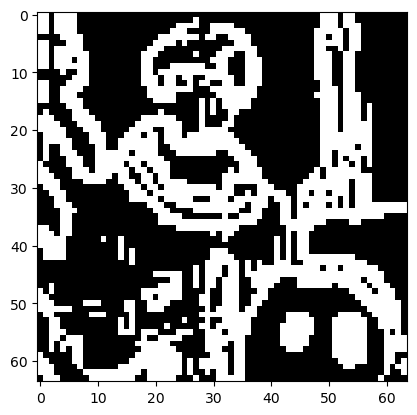

In [61]:
plt.imshow(sobel_image > model.threshold.item(), cmap='gray')

# The `scipy` optim
No clue if this is right?

In [57]:
from scipy.optimize import minimize

In [80]:
def func(thresh):
    running_loss = 0
    for x, y in loader:
        out = torch.tensor(sobel(np.array(x)) > thresh).float()
        loss = criterion(out, y)
    return loss

In [55]:
res = minimize(func, .2, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

print('Minimized value: ', res.x)

Optimization terminated successfully.
         Current function value: 29.125977
         Iterations: 27
         Function evaluations: 68
Minimized value:  [0.035]


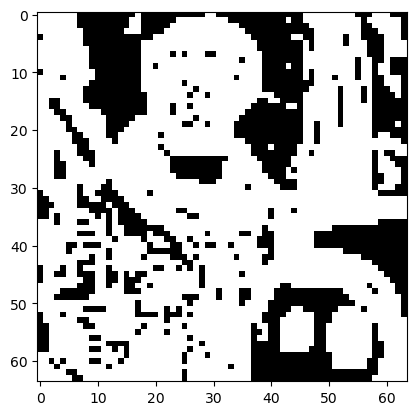

In [62]:
plt.imshow(sobel_image > res.x, cmap='gray')

# Random grid search

In [4]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [5]:
criterion = nn.MSELoss()  # since output is between 0 and 1

In [6]:
def func(thresh):
    running_loss = 0
    for x, y in trainloader:
        green = np.array(x[:, 1:2, :, :])
        out = torch.tensor(sobel(green) > thresh).float()
        loss = criterion(out, y)
        running_loss += loss.item()
    running_loss /= len(trainloader)
    return running_loss

In [7]:
from skorch import NeuralNetRegressor

In [8]:
from sklearn.base import BaseEstimator

class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=nn.ReLU()):
        super().__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, num_units)
        self.output = nn.Linear(num_units, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.output(X)
        return X

In [9]:
X, y = next(iter(trainloader))
X = X[:, 1:2, :, :]

In [10]:
from kornia.filters import sobel

In [11]:
sobel(X).shape

torch.Size([100, 1, 256, 256])

In [36]:
# Define a learnable threshold model
class ThresholdModel(nn.Module):
    def __init__(self, t=.5):
        super().__init__()
        self.threshold = nn.Parameter(torch.tensor([t]))  # learnable scalar

    def forward(self, x):
        sobimg = sobel(x)
        out = sobimg - self.threshold
        return  out

In [37]:
net = NeuralNetRegressor(
    ThresholdModel,
    module__t=.6,
    max_epochs=10,
    # criterion=nn.CrossEntropyLoss(),
    # lr=0.1,
    # Shuffle training data on each epoch
    # iterator_train__shuffle=True,
)

In [38]:
X.shape, y.shape

(torch.Size([100, 1, 256, 256]), torch.Size([100, 1, 256, 256]))

In [39]:
net.fit(X, y)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2275.0303     2163.1680  0.1160
      2     2269.1826     2157.5459  0.1106
      3     2263.5674     2152.1460  0.1118
      4     2258.1741     2146.9600  0.1118
      5     2252.9944     2141.9790  0.1096
      6     2248.0195     2137.1956  0.1160
      7     2243.2424     2132.6011  0.1121
      8     2238.6541     2128.1885  0.1112
      9     2234.2473     2123.9507  0.1172
     10     2230.0151     2119.8804  0.1126


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=ThresholdModel(),
)

In [40]:
from sklearn.model_selection import GridSearchCV

params = {
    'module__t': [0.01, 0.2, 0.5, 0.8],
    # 'max_epochs': [10, 20],
    # 'module__num_units': [10, 20],
}
gs = GridSearchCV(net, params, refit=False, cv=2, scoring='r2')

gs.fit(X, y)
print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2608.0432     1666.5155  0.0728
      2     2601.1182     1662.2086  0.0683
      3     2594.4666     1658.1183  0.0677
      4     2588.0796     1654.2350  0.0678
      5     2581.9453     1650.5492  0.0681
      6     2576.0532     1647.0529  0.0684
      7     2570.3948     1643.7377  0.0675
      8     2564.9609     1640.5950  0.0681
      9     2559.7419     1637.6174  0.0682
     10     2554.7295     1634.7977  0.0680
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2615.9153     2160.9526  0.0685
      2     2609.1252     2155.1001  0.0694


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

      3     2602.6035     2149.4924  0.0739
      4     2596.3403     2144.1204  0.0719
      5     2590.3250     2138.9729  0.0747
      6     2584.5481     2134.0417  0.0744
      7     2578.9998     2129.3179  0.0731
      8     2573.6709     2124.7930  0.0689
      9     2568.5530     2120.4592  0.0683
     10     2563.6387     2116.3081  0.0695
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     1691.1837     2162.8293  0.0683
      2     1687.9474     2158.7458  0.0692


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

      3     1684.8389     2154.8052  0.0711
      4     1681.8536     2151.0020  0.0753
      5     1678.9865     2147.3306  0.0749
      6     1676.2328     2143.7871  0.0754
      7     1673.5883     2140.3660  0.0726
      8     1671.0483     2137.0632  0.0698
      9     1668.6094     2133.8743  0.0703
     10     1666.2668     2130.7949  0.0754
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2613.1045     1669.6924  0.0698
      2     2605.9788     1665.2266  0.0694


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

      3     2599.1353     1660.9846  0.0706
      4     2592.5630     1656.9561  0.0687
      5     2586.2512     1653.1315  0.0674
      6     2580.1887     1649.5026  0.0722
      7     2574.3669     1646.0602  0.0676
      8     2568.7749     1642.7963  0.0687
      9     2563.4048     1639.7029  0.0693
     10     2558.2476     1636.7727  0.0675
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2620.9277     2165.2810  0.0680
      2     2613.9390     2159.2478  0.0680


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

      3     2607.2263     2153.4666  0.0696
      4     2600.7800     2147.9275  0.0706
      5     2594.5891     2142.6204  0.0686
      6     2588.6433     2137.5356  0.0709
      7     2582.9324     2132.6653  0.0739
      8     2577.4480     2127.9995  0.0681
      9     2572.1814     2123.5300  0.0676
     10     2567.1226     2119.2495  0.0683
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     1694.6555     2167.1875  0.0682
      2     1691.2812     2162.9519  0.0681


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

      3     1688.0411     2158.8645  0.0714
      4     1684.9288     2154.9194  0.0691
      5     1681.9397     2151.1121  0.0694
      6     1679.0693     2147.4373  0.0678
      7     1676.3127     2143.8899  0.0686
      8     1673.6648     2140.4656  0.0694
      9     1671.1222     2137.1589  0.0682
     10     1668.6797     2133.9670  0.0687
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2621.2432     1674.8495  0.0679
      2     2613.7947     1670.1276  0.0670


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

      3     2606.6418     1665.6405  0.0691
      4     2599.7725     1661.3771  0.0673
      5     2593.1748     1657.3291  0.0668
      6     2586.8389     1653.4857  0.0685
      7     2580.7529     1649.8386  0.0668
      8     2574.9089     1646.3789  0.0674
      9     2569.2959     1643.0984  0.0682
     10     2563.9048     1639.9891  0.0680
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2628.9888     2172.2561  0.0679
      2     2621.6807     2165.9314  0.0685


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

      3     2614.6619     2159.8713  0.0696
      4     2607.9214     2154.0642  0.0678
      5     2601.4475     2148.4998  0.0698
      6     2595.2292     2143.1692  0.0725
      7     2589.2585     2138.0615  0.0678
      8     2583.5237     2133.1685  0.0702
      9     2578.0159     2128.4814  0.0730
     10     2572.7258     2123.9919  0.0704
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     1700.2838     2174.2102  0.0688
      2     1696.6868     2169.7283  0.0682


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

      3     1693.2324     2165.4031  0.0712
      4     1689.9143     2161.2300  0.0686
      5     1686.7281     2157.2026  0.0683
      6     1683.6681     2153.3157  0.0673
      7     1680.7289     2149.5647  0.0686
      8     1677.9067     2145.9431  0.0728
      9     1675.1958     2142.4475  0.0691
     10     1672.5923     2139.0728  0.0680
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2629.5613     1680.1799  0.0676
      2     2621.7842     1675.1951  0.0672


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

      3     2614.3149     1670.4557  0.0690
      4     2607.1411     1665.9520  0.0677
      5     2600.2522     1661.6731  0.0677
      6     2593.6353     1657.6096  0.0676
      7     2587.2803     1653.7522  0.0686
      8     2581.1780     1650.0918  0.0664
      9     2575.3167     1646.6189  0.0676
     10     2569.6875     1643.3259  0.0668
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2637.2292     2179.4045  0.0715
      2     2629.5955     2172.7817  0.0694


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

      3     2622.2629     2166.4351  0.0699
      4     2615.2212     2160.3535  0.0708
      5     2608.4583     2154.5261  0.0748
      6     2601.9631     2148.9426  0.0759
      7     2595.7249     2143.5928  0.0790
      8     2589.7339     2138.4678  0.0692
      9     2583.9802     2133.5579  0.0690
     10     2578.4548     2128.8547  0.0687
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     1706.0922     2181.4060  0.1031
      2     1702.2649     2176.6707  0.0698


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

      3     1698.5896     2172.1018  0.0728
      4     1695.0597     2167.6938  0.0784
      5     1691.6696     2163.4407  0.0696
      6     1688.4139     2159.3357  0.0682
      7     1685.2870     2155.3745  0.0727
      8     1682.2842     2151.5513  0.0715
      9     1679.3998     2147.8611  0.0760
     10     1676.6298     2144.2993  0.0765
nan {'module__t': 0.01}


/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

In [42]:
class FunctionWrapper(BaseEstimator):
    def __init__(self, x=0.0):
        self.x = x

    def fit(self, X=None, y=None):
        return self

    def score(self, X=None, y=None):
        # GridSearchCV maximizes score, so we return the negative of the function
        return -func(self.x)

In [44]:
param_grid = {
    'x': np.random.uniform(0, 1, 1000)
}

search = GridSearchCV(FunctionWrapper(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=[(slice(None), slice(None))])
search.fit(sobel_image, label)

print("Minimized value:", search.best_params_['x'])

NameError: name 'sobel_image' is not defined

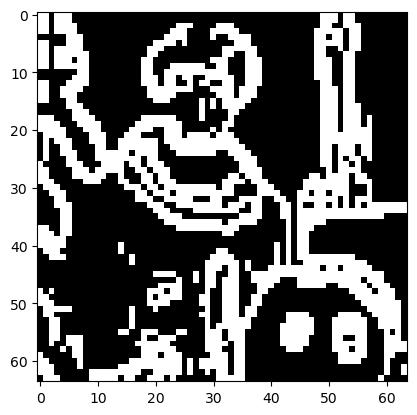

In [129]:
plt.imshow(sobel_image > search.best_params_['x'], cmap='gray')